In [1]:
import numpy as np
from pathlib import Path
import shutil
from scipy.sparse.linalg import gmres
from scipy.sparse import  diags
def cheb(n):
    if n == 0:
        return 0,1
    else:
        x = [np.cos(i*np.pi/n) for i in range(0,n+1)]
        c = np.ones((n+1))
        c[0]+=1
        c[-1]+=1
        d = np.zeros((n+1,n+1))
        for i in range(0,n+1):
            for j in range(0,n+1):
                if i==j:
                    continue
                d[i][j] = c[i]/c[j] * (-1)**(i+j)/(x[i]-x[j])
        for i in range(0,n+1):
            d[i][i] = -np.sum(d[i][:])
        return d, x

def get_second_derivative(M, dt):
    k = 2 * np.pi * np.fft.fftfreq(M, dt)
    D2 = np.real(np.fft.ifft(-k**2 * np.fft.fft(np.eye(M))))
    return D2


def get_first_derivative(M, dt):
    k = 2 * np.pi * np.fft.fftfreq(M, dt)
    D1 = np.real(np.fft.ifft(-1j * k * np.fft.fft(np.eye(M))))  # Sign corrected
    return D1
def puasson_polar_simple(r,L,t,omega, n=100,M=100,r0=1,r1=2,angle_of_attack = 0):


    rr, tt = np.meshgrid(r, t)

    rr, tt = rr.flatten(), tt.flatten()

    f = -omega.flatten()

    boundary_indices = np.where(np.isclose(rr, r1, atol=1e-14) | np.isclose(rr, r0, atol=1e-14))[0]


    L[boundary_indices, :] = 0  # Zero out the rows for boundary nodes
    for b in boundary_indices:
        L[b, b] = 1  # Set diagonal to 1 for Dirichlet condition
        if np.isclose(rr[b], r1, atol=1e-14):
            # Apply boundary condition at r1
            f[b] = r1 * (np.sin(tt[b]) * np.cos(angle_of_attack)
                        - np.cos(tt[b]) * np.sin(angle_of_attack))
        elif np.isclose(rr[b], r0, atol=1e-14):
            # Apply boundary condition at r0
            f[b] = 0


    u = np.linalg.solve(L,f)
    u = u.reshape(M, n+1)

    return u
# Vectorized approach for constructing advection operators
def build_advection_operators(dpsidt_mat, dpsidr_mat, rr_mat, ddr, ddt, M, N):
    # Prepare coefficients arrays
    dpsidt_by_r = (dpsidt_mat / rr_mat).reshape(-1, 1)  # Shape: (M*(N+1), 1)
    dpsidr_by_r = (-dpsidr_mat / rr_mat).reshape(-1, 1)  # Shape: (M*(N+1), 1)

    # Construct advection operators using broadcasting
    adv_r_operator = dpsidt_by_r * ddr
    adv_t_operator = dpsidr_by_r * ddt

    return adv_r_operator, adv_t_operator

def navie_iteration3(N=100, M=100, r0=1, r1=2, Re=10, angle_of_attack=0, time=1, cfl=0.5):
    omega = np.zeros((M, N+1))
    psi = np.zeros((M, N+1))

    d, r = cheb(N)
    r = np.array(r)*(r1-r0)/2 + (r0 + r1)/2
    d = d*2/(r1 - r0)
    dt = 2 * np.pi / M
    t = dt * np.arange(1, M+1)

    d2t = get_second_derivative(M, dt)
    d1t = get_first_derivative(M, dt)

    R = 1/np.array(r)
    R = np.diag(R)
    L = np.kron(np.eye(M), np.matmul(R, d) + np.matmul(d, d)) + np.kron(d2t, np.matmul(R, R))

    ddr = np.kron(np.eye(M), d)
    ddt = np.kron(d1t, np.eye(N+1))

    # Time step calculation
    dr = abs(r[1] - r[0])
    max_velocity = 1.0
    cfl_convective = cfl * dr / max_velocity
    Delta_t = cfl_convective
    T = int(2 * r1 / (Delta_t) * time)
    print(f'Time steps:{T}')
    print(f'Step time: {Delta_t}')

    # Generate boundary indices
    rr, tt = np.meshgrid(r, t)

    rr, tt = rr.flatten(), tt.flatten()

    r1_boundary_indices = np.where(np.isclose(rr, r1, atol=1e-14))[0]
    r0_boundary_indices = np.where(np.isclose(rr, r0, atol=1e-14))[0]

    boundary_indices = np.concatenate([r0_boundary_indices, r1_boundary_indices])

    # Create directories for output
    for dir_name in [f"СС2/psi_snapshots_{Re}_{N}_{M}", f"СС2/omega_snapshots_{Re}_{N}_{M}",
                    f"СС2/ur_snapshots_{Re}_{N}_{M}", f"СС2/ut_snapshots_{Re}_{N}_{M}"]:
        psi_dir = Path(dir_name)
        if psi_dir.exists():
            shutil.rmtree(psi_dir)
        psi_dir.mkdir()

        # Create sparse matrices for the advection operators
    I = np.eye(M * (N+1))

    part_implicit_1 = I - (Delta_t / Re) * L

    # Time loop
    for step in range(T):
        omega_old = omega.copy()
        psi_old = psi.copy()

        # Solve Poisson equation for psi using omega_old
        psi = puasson_polar_simple(r=r, t=t, L=L, omega=omega_old, n=N, M=M, r0=r0, r1=r1, angle_of_attack=angle_of_attack)

        max_change = np.abs(psi - psi_old).max()
      #  print(f"Iteration {step}: Max ψ change = {max_change:.2e}")
        if max_change > 1e12 or max_change < 1e-8:
            return psi, omega, r, t

        # Compute velocity field from psi (will be used to linearize the advection term)
        dpsidr_mat = np.matmul(ddr, psi.flatten()).reshape((M, N+1))
        dpsidt_mat = np.matmul(ddt, psi.flatten()).reshape((M, N+1))
        rr_mat = np.repeat(r.reshape(1, -1), M, axis=0)  # Shape (M, N+1)


        # Build advection operators using the vectorized function
        adv_r_operator, adv_t_operator = build_advection_operators(
            dpsidt_mat, dpsidr_mat, rr_mat, ddr, ddt, M, N)

        # Combine to form the full advection operator
        adv_operator = adv_r_operator + adv_t_operator

        # Construct the full implicit matrix
        A_implicit = part_implicit_1 + Delta_t * adv_operator

        # Apply boundary conditions to A_implicit
        A_implicit[boundary_indices, :] = 0.0
        A_implicit[boundary_indices, boundary_indices] = 1.0

        # Build RHS (simpler now since advection is implicit)
        RHS = omega_old.flatten()

        # Apply BC to RHS
        ut_star = -np.matmul(ddr, psi.flatten())
        ut_star[r0_boundary_indices] = 0

        RHS[r0_boundary_indices] = np.matmul(ddr, ut_star)[r0_boundary_indices]
        RHS[r1_boundary_indices] = 0

        # Solve for new omega
        # Simple diagonal preconditioner
        diagonal = A_implicit.diagonal()
        M_precond = diags(1.0/diagonal)
        omega_new_flat, exitCode = gmres(A_implicit, RHS,
                                         #tol=1e-6,
                                         maxiter=100,
                                         M=M_precond,
                                         restart=30)
        #omega_new_flat,exitCode = gmres(A_implicit, RHS)
        omega = omega_new_flat.reshape((M, N+1))

        # Compute velocity components for output
        ut = -dpsidr_mat
        ur = dpsidt_mat/rr_mat

    return psi, omega, r, t,ur,ut


In [ ]:

r1 = 24
r0 = 1
N = 30
M = N
Re = 17
time = 0.1
angle_of_attack = 0
cfl = 0.9


In [ ]:
!pip install cupy-cuda12x
!pip install numba

In [ ]:

r1 = 24
r0 = 1
N = 30
M = N
Re = 17
time = 0.1
angle_of_attack = 0
cfl = 0.9

psi, omega, r, t,ur,ut = navie_iteration3(N = N,M=M,r0 = r0,r1=r1,Re =Re,angle_of_attack=angle_of_attack,time = time,cfl = cfl)

Time steps:84
Step time: 0.05669838293837195


KeyboardInterrupt: 

In [2]:
from time import time as tratata
import numpy as np

r1 = 24
r0 = 1
N = 50
M = N
Re = 17
time = 0.1
angle_of_attack = 0
cfl = 0.9

times = [0.1, 0.2, 0.4, 0.6]

timing_results = []

for sim_time in times:
    print(f"Running simulation with time = {sim_time}")

    # Start timing
    time_start = tratata()

    # Run simulation
    psi, omega, r, t, ur, ut = navie_iteration3(
        N=N, M=M, r0=r0, r1=r1, Re=Re,
        angle_of_attack=angle_of_attack, time=sim_time, cfl=cfl
    )

    # Stop timing
    time_stop = tratata()

    # Calculate elapsed time
    elapsed_time = time_stop - time_start

    # Store result
    timing_results.append({
        'time_param': sim_time,
        'elapsed_seconds': elapsed_time
    })

    print(f"Simulation completed in {elapsed_time:.2f} seconds")

# Print summary
print("\nSummary of timing results:")
for result in timing_results:
    print(f"Time parameter: {result['time_param']}, Elapsed time: {result['elapsed_seconds']:.2f} seconds")

Running simulation with time = 0.1
Time steps:235
Step time: 0.02042336076738707
Simulation completed in 137.86 seconds
Running simulation with time = 0.2
Time steps:470
Step time: 0.02042336076738707
Simulation completed in 268.35 seconds
Running simulation with time = 0.4
Time steps:940
Step time: 0.02042336076738707
Simulation completed in 531.69 seconds
Running simulation with time = 0.6
Time steps:1410
Step time: 0.02042336076738707
Simulation completed in 803.59 seconds

Summary of timing results:
Time parameter: 0.1, Elapsed time: 137.86 seconds
Time parameter: 0.2, Elapsed time: 268.35 seconds
Time parameter: 0.4, Elapsed time: 531.69 seconds
Time parameter: 0.6, Elapsed time: 803.59 seconds


In [3]:
import matplotlib.pyplot as plt

In [4]:

def everything_everywhere_all_at_once(N,M,r,t,ur_history,ut_history,psi_history,omega_history, step = -1,Re = 10,zoom = 8):
    ur = ur_history
    ut = ut_history
    omega = omega_history
    psi = psi_history

    t = np.insert(t, 0, 2 * np.pi)
    ur = np.insert(ur, 0, ur[-1], axis=0)
    ut = np.insert(ut, 0, ut[-1], axis=0)
    omega = np.insert(omega,0,omega[-1],axis = 0)
    psi = np.insert(psi,0,psi[-1],axis=0)
    rr, tt = np.meshgrid(r, t)
    xx = rr * np.cos(tt)
    yy = rr * np.sin(tt)
    u_mag = np.sqrt(ur**2 + ut**2)
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle(f'Reynols = {Re}, radial points = {N}, angular points = {M}')
    # Plot 1: Velocity magnitude
    cf1 = axes[0,0].contourf(xx, yy, u_mag, levels=30, cmap='jet',extend = 'max')
    cbar1 = fig.colorbar(cf1, ax=axes[0,0], label='Velocity magnitude (m/s)',
                        ticks=np.linspace(u_mag.min(), u_mag.max(), 12))
    axes[0,0].set_title('Velocity Magnitude')

    # Plot 2: Streamfunction
    cf2 = axes[0,1].contour(xx, yy, psi, levels=100, cmap='inferno')
    cbar2 = fig.colorbar(cf2, ax=axes[0,1], label='Streamfunction (ψ)',
                        ticks=np.linspace(psi.min(), psi.max(), 11))
    axes[0,1].set_title('Streamfunction')

    # Plot 3: Vorticity


    axes[1,0].set_xlim(-zoom*r.min(), zoom*r.min())
    axes[1,0].set_ylim(-zoom*r.min(), zoom*r.min())
    # Create a filled contour plot of velocity magnitude
    cf = axes[1,0].contourf(xx, yy, u_mag, levels=30, cmap='jet', alpha=0.7)

    # Overlay streamfunction contours
    cs = axes[1,0].contour(xx, yy, psi, levels=50, colors='k', linewidths=0.5)

    # Add colorbar
    cbar = plt.colorbar(cf, label='Velocity Magnitude (m/s)')

    axes[1,0].set_title(f'Velocity Magnitude with Streamfunction Overlay')
    plt.tight_layout()
    # Save as SVG (Scalable Vector Graphics)
    #plt.savefig(f"Circle Profile Re = {Re}.svg", format="svg", bbox_inches="tight", dpi=300)
    # response = send_svg_to_telegram(f"Circle Profile Re = {Re}.svg", bot_token, chat_id, caption=f"Streamlines near cylinder (Re={Re})")
    # print(response)
    plt.show()


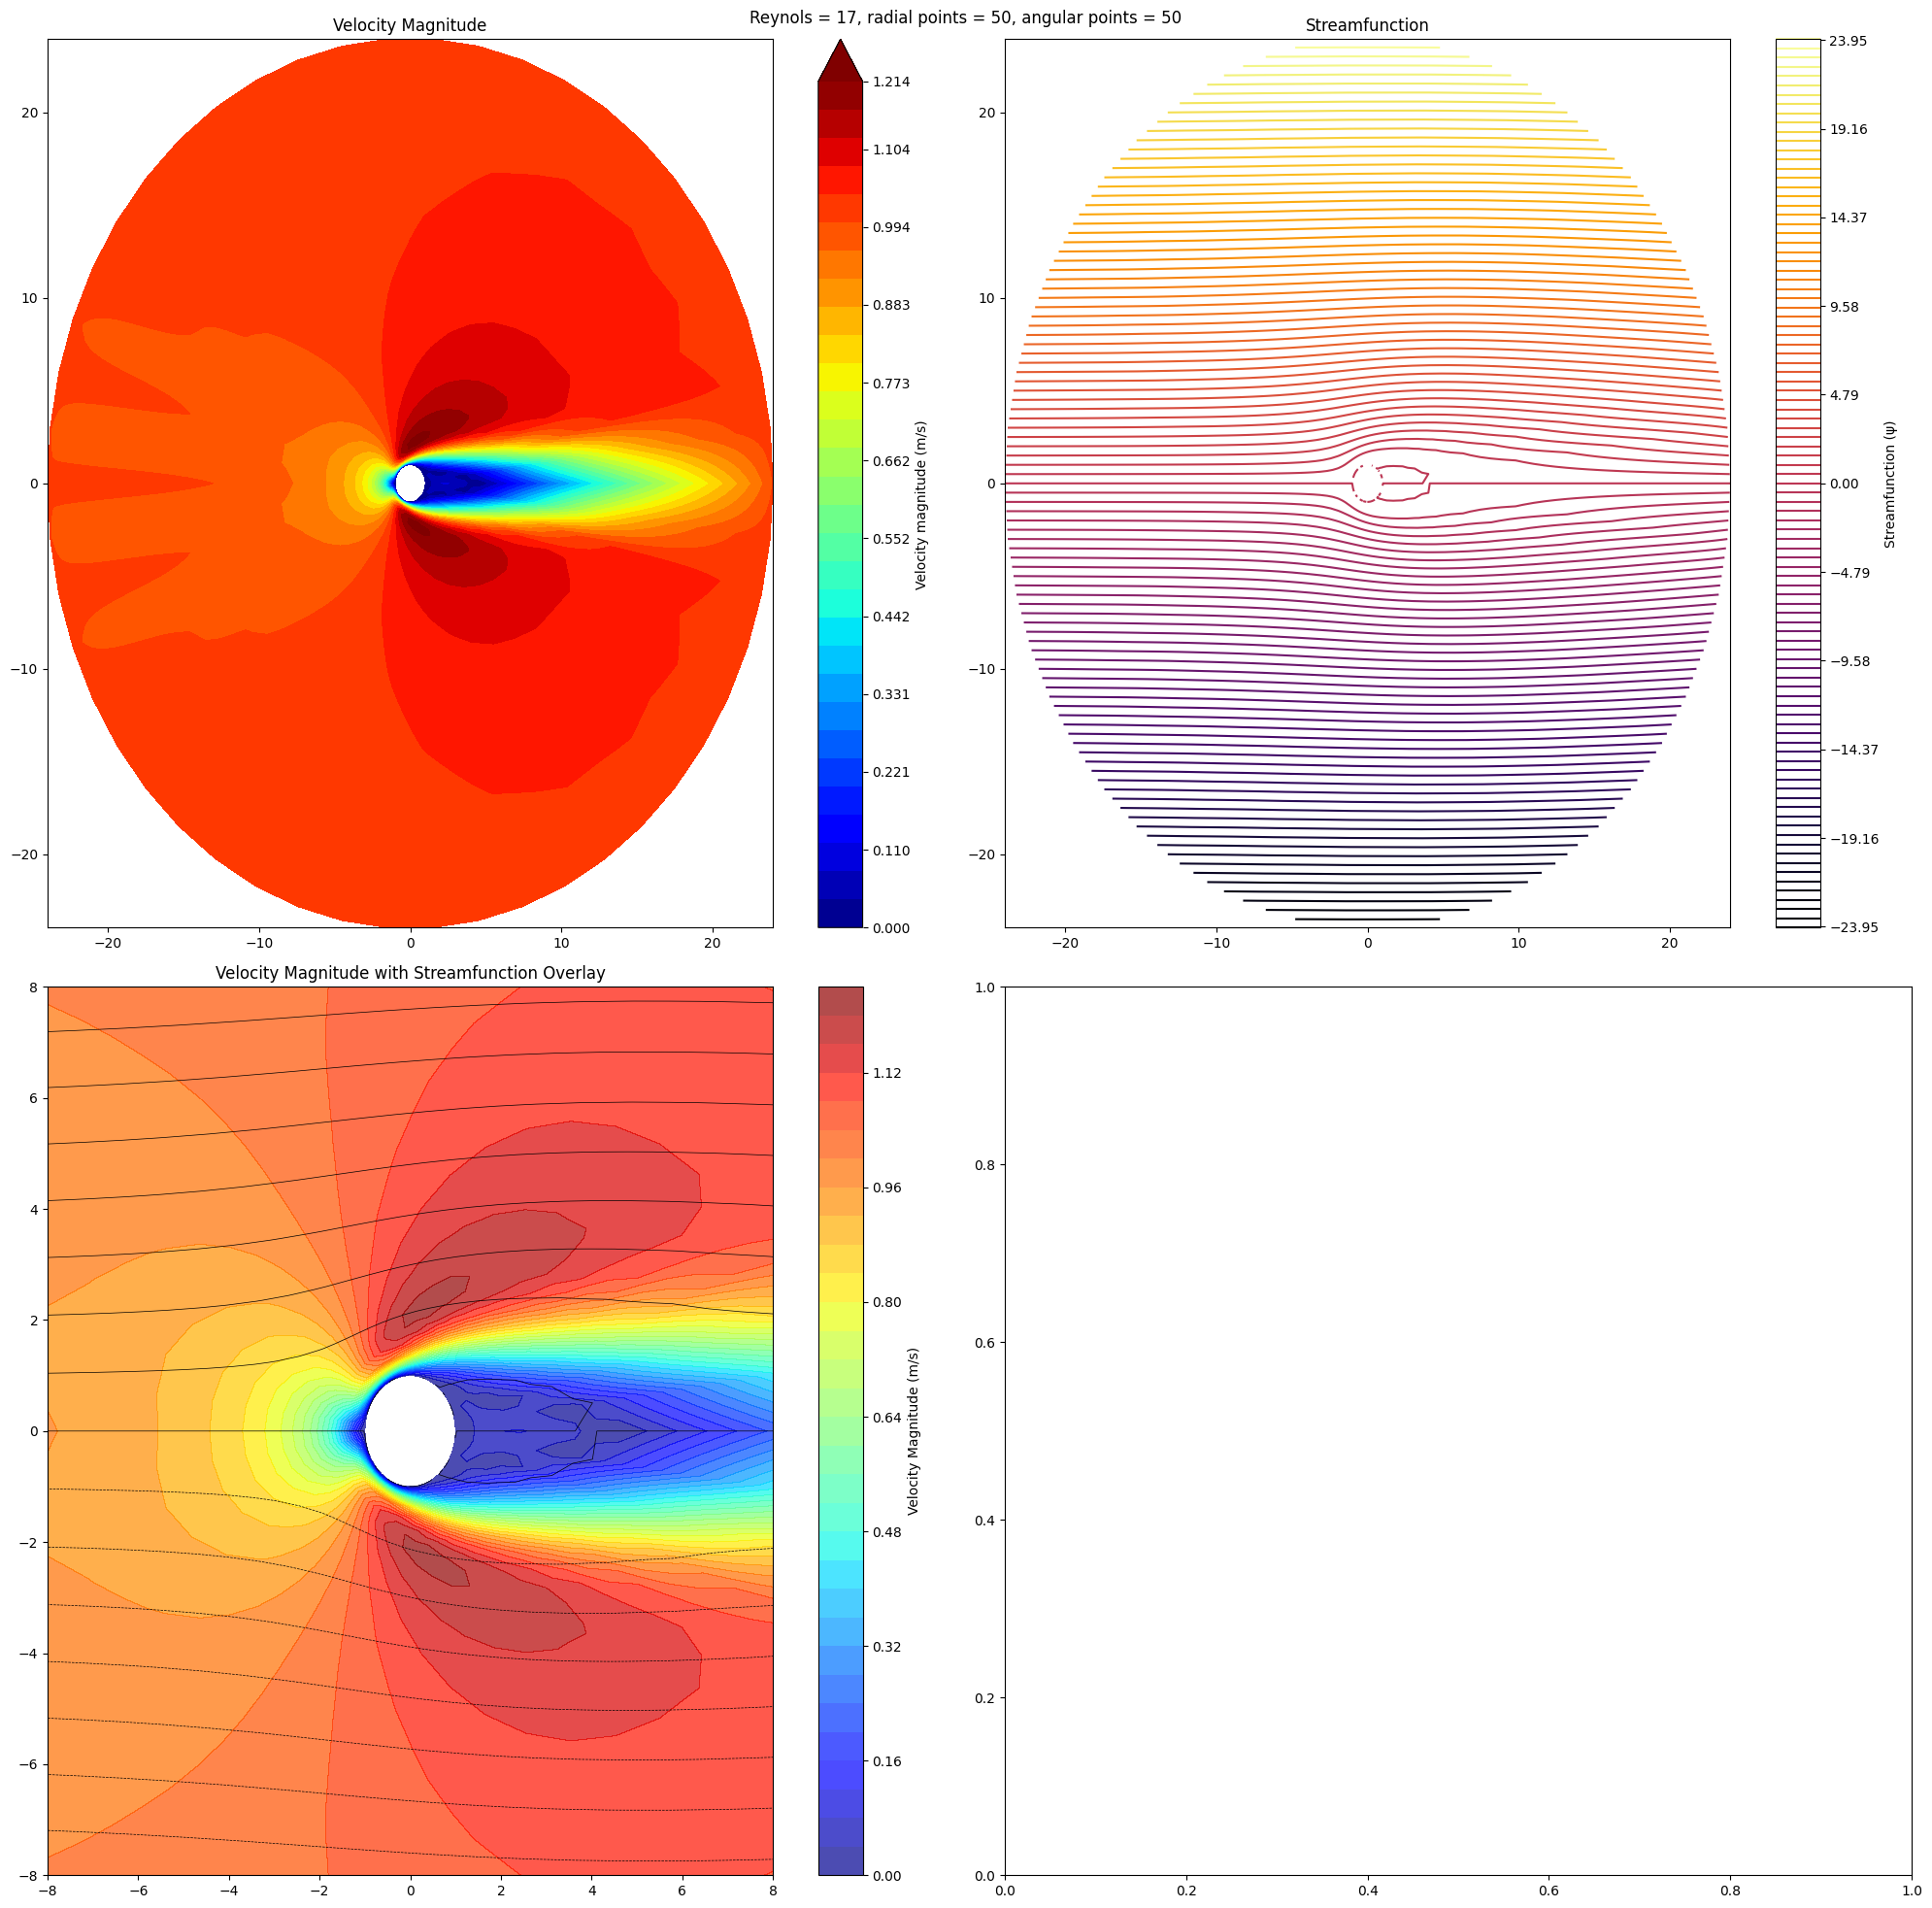

In [5]:
everything_everywhere_all_at_once(N,M,r,t,ur,ut,psi,omega,-1,Re)


In [6]:
import cupy as cp

def cheb(n):
    if n == 0:
        return 0, 1
    else:
        x = cp.cos(cp.arange(n+1) * cp.pi / n)
        c = cp.ones(n+1)
        c[0] += 1
        c[-1] += 1
        d = cp.zeros((n+1, n+1))
        for i in range(n+1):
            for j in range(n+1):
                if i == j:
                    continue
                d[i, j] = c[i] / c[j] * (-1)**(i+j) / (x[i] - x[j])
        for i in range(n+1):
            d[i, i] = -cp.sum(d[i, :])
        return d, x

def get_second_derivative(M, dt):
    k = 2 * cp.pi * cp.fft.fftfreq(M, dt)
    D2 = cp.real(cp.fft.ifft(-k**2 * cp.fft.fft(cp.eye(M, dtype=cp.complex64))))
    return D2

def get_first_derivative(M, dt):
    k = 2 * cp.pi * cp.fft.fftfreq(M, dt)
    D1 = cp.real(cp.fft.ifft(-1j * k * cp.fft.fft(cp.eye(M, dtype=cp.complex64))))
    return D1

def puasson_polar_simple(r, L, t, omega, n=100, M=100, r0=1, r1=2, angle_of_attack=0):
    rr, tt = cp.meshgrid(r, t)
    rr, tt = rr.flatten(), tt.flatten()
    f = -omega.flatten()

    boundary_indices = cp.where(cp.isclose(rr, r1, atol=1e-14) | cp.isclose(rr, r0, atol=1e-14))[0]

    L[boundary_indices, :] = 0
    for b in boundary_indices:
        L[b, b] = 1
        if cp.isclose(rr[b], r1, atol=1e-14):
            f[b] = r1 * (cp.sin(tt[b]) * cp.cos(angle_of_attack) - cp.cos(tt[b]) * cp.sin(angle_of_attack))
        elif cp.isclose(rr[b], r0, atol=1e-14):
            f[b] = 0

    u = cp.linalg.solve(L, f)
    u = u.reshape(M, n+1)
    return u

def build_advection_operators(dpsidt_mat, dpsidr_mat, rr_mat, ddr, ddt, M, N):
    dpsidt_by_r = (dpsidt_mat / rr_mat).reshape(-1, 1)
    dpsidr_by_r = (-dpsidr_mat / rr_mat).reshape(-1, 1)
    adv_r_operator = dpsidt_by_r * ddr
    adv_t_operator = dpsidr_by_r * ddt
    return adv_r_operator, adv_t_operator


def navie_iteration3(N=100, M=100, r0=1, r1=2, Re=10, angle_of_attack=0, time=1, cfl=0.5):
    omega = cp.zeros((M, N+1))
    psi = cp.zeros((M, N+1))

    d, r = cheb(N)
    r = r * (r1 - r0)/2 + (r0 + r1)/2
    d = d*2/(r1 - r0)
    dt = 2 * cp.pi / M
    t = dt * cp.arange(1, M+1)

    d2t = get_second_derivative(M, dt)
    d1t = get_first_derivative(M, dt)

    R = 1/r
    R = cp.diag(R)
    L = cp.kron(cp.eye(M), cp.matmul(R, d) + cp.matmul(d, d)) + cp.kron(d2t, cp.matmul(R, R))

    ddr = cp.kron(cp.eye(M), d)
    ddt = cp.kron(d1t, cp.eye(N+1))

    # Time step calculation
    dr = abs(r[1] - r[0])
    max_velocity = 1.0
    cfl_convective = cfl * dr / max_velocity
    Delta_t = cfl_convective
    T = int(2 * r1 / (Delta_t) * time)
    print(f'Time steps:{T}')
    print(f'Step time: {Delta_t}')

    # Generate boundary indices
    rr, tt = cp.meshgrid(r, t)

    rr, tt = rr.flatten(), tt.flatten()

    r1_boundary_indices = cp.where(cp.isclose(rr, r1, atol=1e-14))[0]
    r0_boundary_indices = cp.where(cp.isclose(rr, r0, atol=1e-14))[0]

    boundary_indices = cp.concatenate([r0_boundary_indices, r1_boundary_indices])

    # Create directories for output
    for dir_name in [f"СС2/psi_snapshots_{Re}_{N}_{M}", f"СС2/omega_snapshots_{Re}_{N}_{M}",
                    f"СС2/ur_snapshots_{Re}_{N}_{M}", f"СС2/ut_snapshots_{Re}_{N}_{M}"]:
        psi_dir = Path(dir_name)
        if psi_dir.exists():
            shutil.rmtree(psi_dir)
        psi_dir.mkdir()

    # Create sparse matrices for the advection operators
    I = cp.eye(M * (N+1))

    part_implicit_1 = I - (Delta_t / Re) * L

    # Time loop
    for step in range(T):
        omega_old = omega.copy()
        psi_old = psi.copy()

        # Solve Poisson equation for psi using omega_old
        psi = puasson_polar_simple(r=r, t=t, L=L, omega=omega_old, n=N, M=M, r0=r0, r1=r1, angle_of_attack=angle_of_attack)

        max_change = cp.abs(psi - psi_old).max()
        if max_change > 1e12 or max_change < 1e-8:
            return psi, omega, r, t

        # Compute velocity field from psi
        dpsidr_mat = cp.matmul(ddr, psi.flatten()).reshape((M, N+1))
        dpsidt_mat = cp.matmul(ddt, psi.flatten()).reshape((M, N+1))
        rr_mat = cp.repeat(r.reshape(1, -1), M, axis=0)  # Shape (M, N+1)

        # Build advection operators
        adv_r_operator, adv_t_operator = build_advection_operators(
            dpsidt_mat, dpsidr_mat, rr_mat, ddr, ddt, M, N)

        # Combine to form the full advection operator
        adv_operator = adv_r_operator + adv_t_operator

        # Construct the full implicit matrix
        A_implicit = part_implicit_1 + Delta_t * adv_operator

        # Apply boundary conditions to A_implicit
        A_implicit[boundary_indices, :] = 0.0
        A_implicit[boundary_indices, boundary_indices] = 1.0

        # Build RHS
        RHS = omega_old.flatten()

        # Apply BC to RHS
        ut_star = -cp.matmul(ddr, psi.flatten())
        ut_star[r0_boundary_indices] = 0

        RHS[r0_boundary_indices] = cp.matmul(ddr, ut_star)[r0_boundary_indices]
        RHS[r1_boundary_indices] = 0

        # Solve for new omega
        # Note: You'll need to implement diags with CuPy or use an alternative
        # diagonal = A_implicit.diagonal()
        # M_precond = diags(1.0/diagonal)

        omega_new_flat = cp.linalg.solve(A_implicit, RHS)
        omega = omega_new_flat.reshape((M, N+1))

        # Compute velocity components for output
        ut = -dpsidr_mat
        ur = dpsidt_mat/rr_mat

    return psi, omega, r, t, ur, ut

In [ ]:

r1 = 24
r0 = 1
N = 30
M = N
Re = 17
time = 0.1
angle_of_attack = 0
cfl = 0.9

psi, omega, r, t,ur,ut = navie_iteration3(N = N,M=M,r0 = r0,r1=r1,Re =Re,angle_of_attack=angle_of_attack,time = time,cfl = cfl)

Time steps:84
Step time: 0.05669838293837195


In [8]:
def everything_everywhere_all_at_once(N, M, r, t, ur_history, ut_history, psi_history, omega_history, step=-1, Re=10, zoom=8):
    # Convert CuPy arrays to NumPy arrays for visualization
    r = cp.asnumpy(r)
    t = cp.asnumpy(t)
    ur = cp.asnumpy(ur_history)
    ut = cp.asnumpy(ut_history)
    omega = cp.asnumpy(omega_history)
    psi = cp.asnumpy(psi_history)

    t = np.insert(t, 0, 2 * np.pi)
    ur = np.insert(ur, 0, ur[-1], axis=0)
    ut = np.insert(ut, 0, ut[-1], axis=0)
    omega = np.insert(omega, 0, omega[-1], axis=0)
    psi = np.insert(psi, 0, psi[-1], axis=0)

    rr, tt = np.meshgrid(r, t)
    xx = rr * np.cos(tt)
    yy = rr * np.sin(tt)
    u_mag = np.sqrt(ur**2 + ut**2)

    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle(f'Reynols = {Re}, radial points = {N}, angular points = {M}')

    # Plot 1: Velocity magnitude
    cf1 = axes[0,0].contourf(xx, yy, u_mag, levels=30, cmap='jet', extend='max')
    cbar1 = fig.colorbar(cf1, ax=axes[0,0], label='Velocity magnitude (m/s)',
                        ticks=np.linspace(u_mag.min(), u_mag.max(), 12))
    axes[0,0].set_title('Velocity Magnitude')

    # Plot 2: Streamfunction
    cf2 = axes[0,1].contour(xx, yy, psi, levels=100, cmap='inferno')
    cbar2 = fig.colorbar(cf2, ax=axes[0,1], label='Streamfunction (ψ)',
                        ticks=np.linspace(psi.min(), psi.max(), 11))
    axes[0,1].set_title('Streamfunction')

    # Plot 3: Vorticity
    axes[1,0].set_xlim(-zoom*r.min(), zoom*r.min())
    axes[1,0].set_ylim(-zoom*r.min(), zoom*r.min())

    # Create a filled contour plot of velocity magnitude
    cf = axes[1,0].contourf(xx, yy, u_mag, levels=30, cmap='jet', alpha=0.7)

    # Overlay streamfunction contours
    cs = axes[1,0].contour(xx, yy, psi, levels=50, colors='k', linewidths=0.5)

    # Add colorbar
    cbar = plt.colorbar(cf, label='Velocity Magnitude (m/s)')

    axes[1,0].set_title('Velocity Magnitude with Streamfunction Overlay')
    plt.tight_layout()
    plt.show()

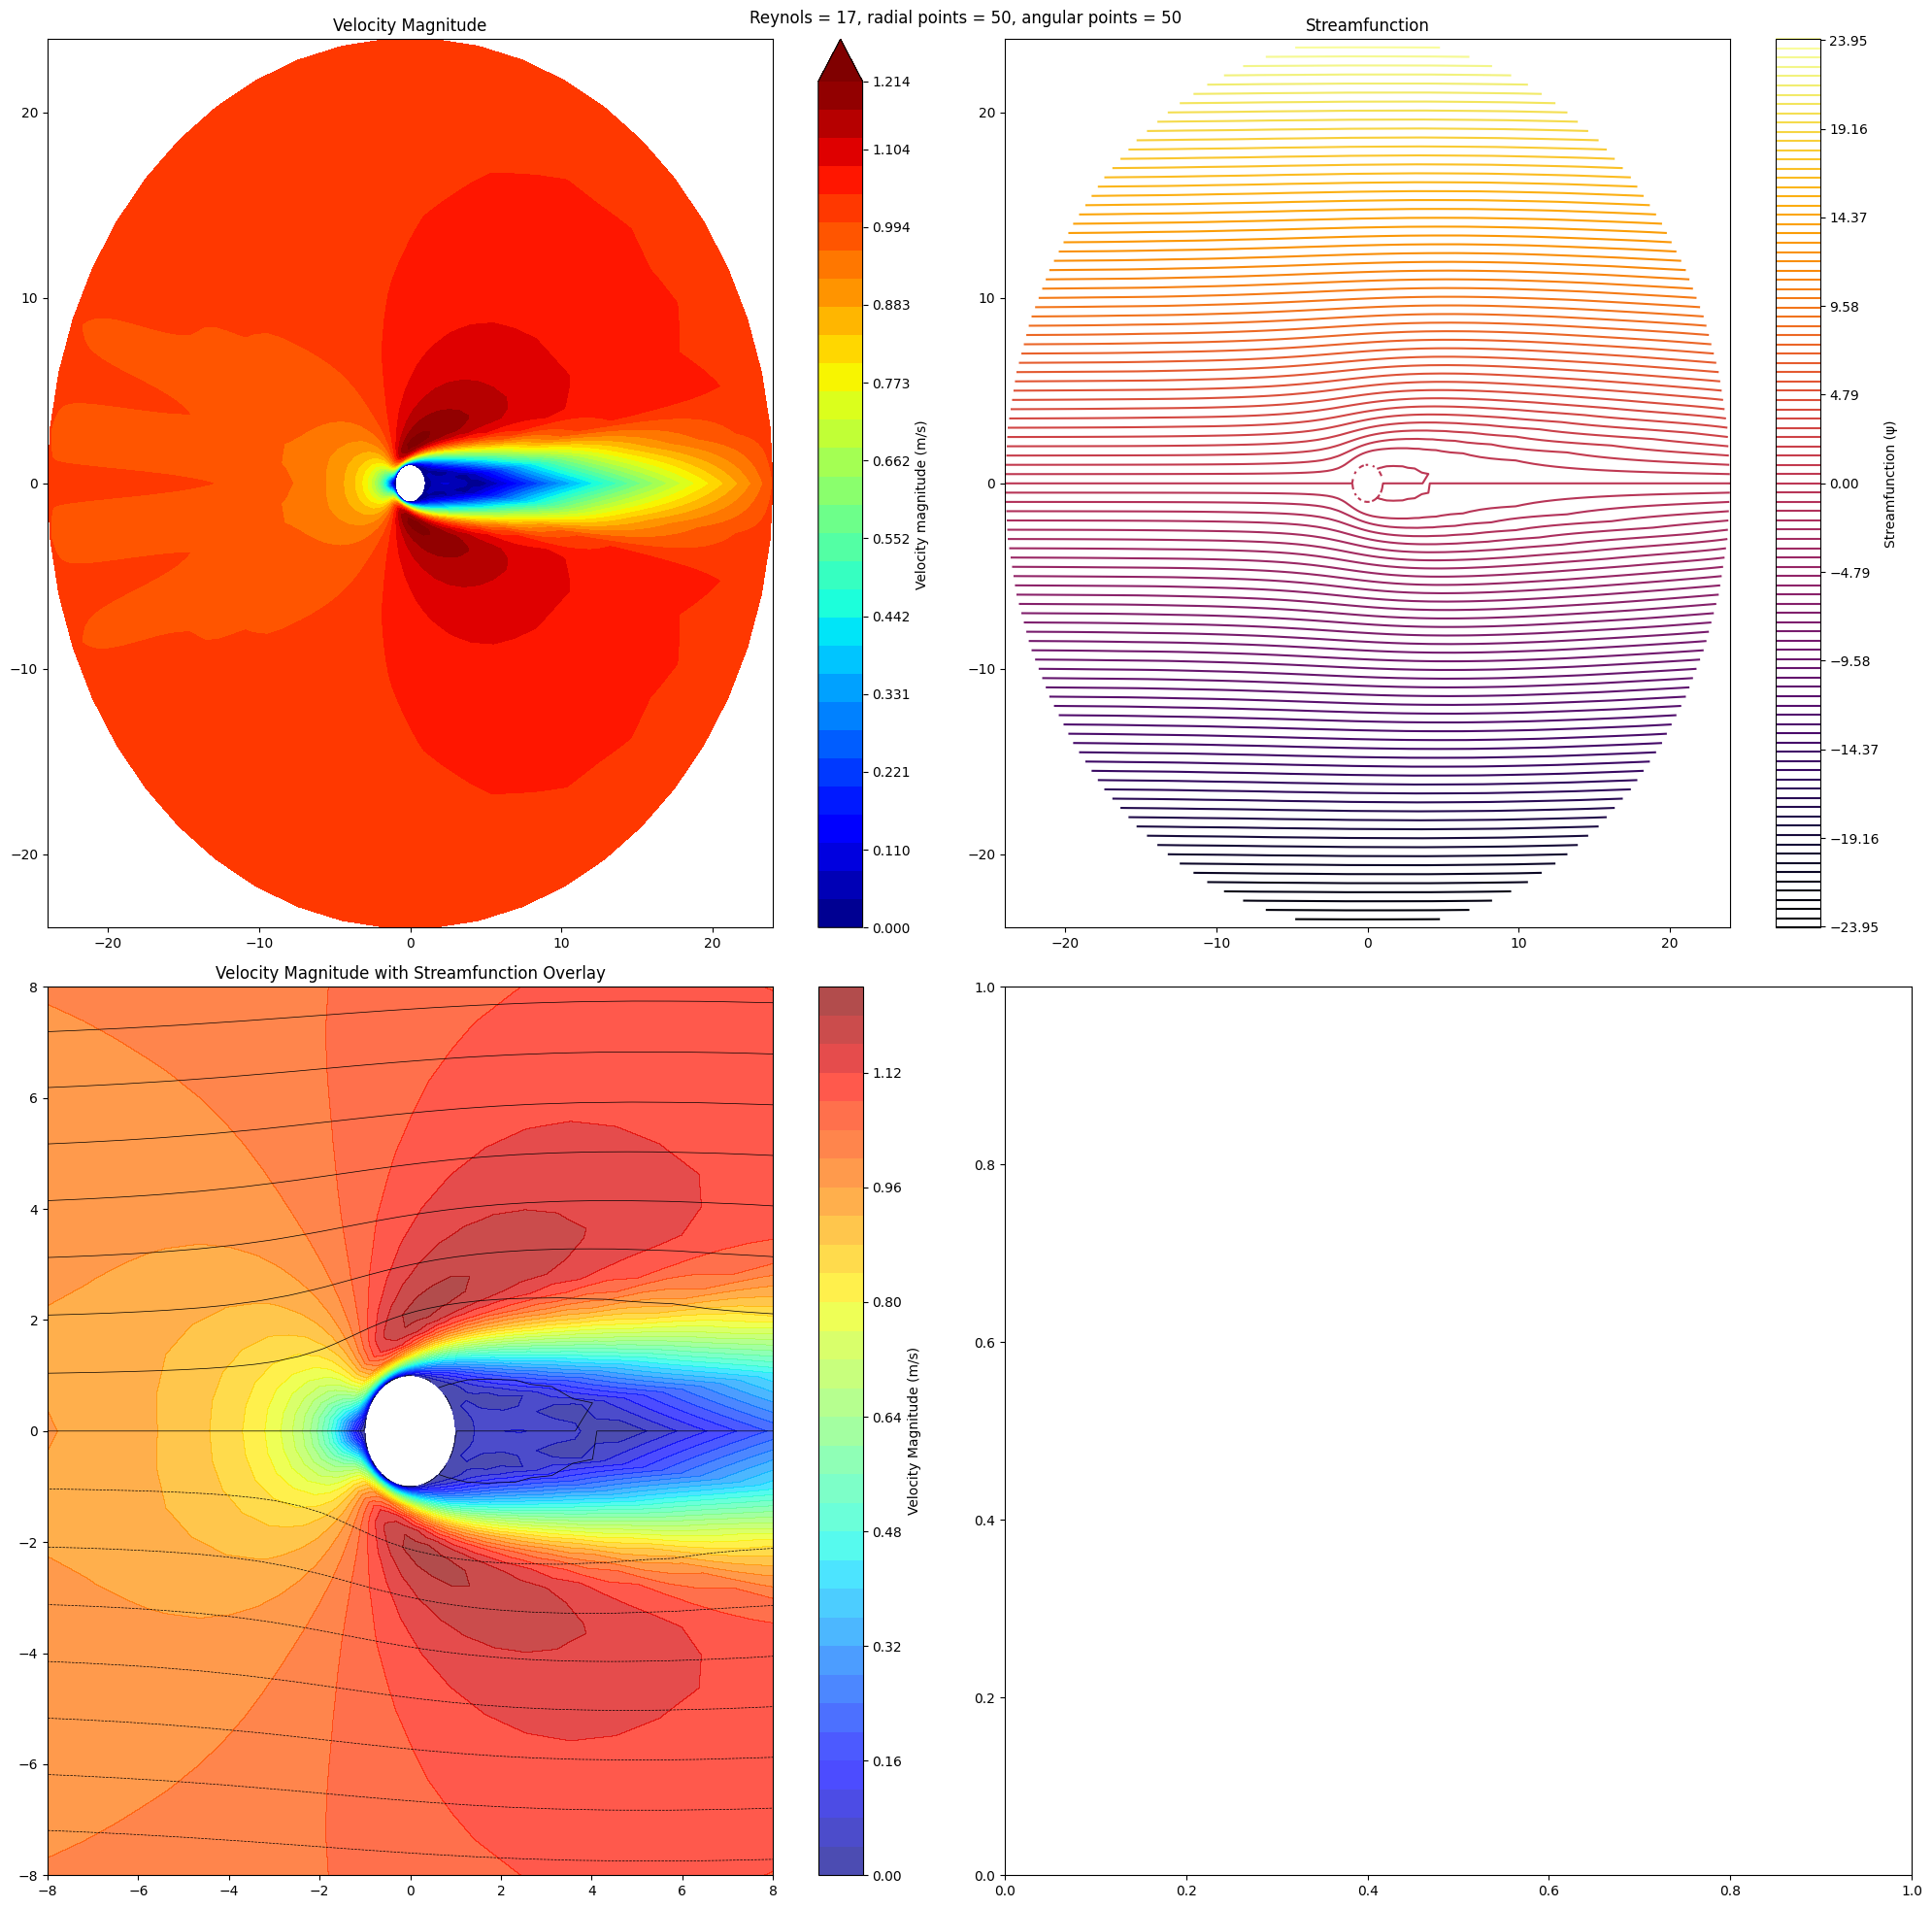

In [9]:
everything_everywhere_all_at_once(N,M,r,t,ur,ut,psi,omega,-1,Re)

In [7]:
from time import time as tratata
import numpy as np

r1 = 24
r0 = 1
N = 50
M = N
Re = 17
time = 0.1
angle_of_attack = 0
cfl = 0.9

times = [0.1, 0.2, 0.4, 0.6]

timing_results2 = []

for sim_time in times:
    print(f"Running simulation with time = {sim_time}")

    # Start timing
    time_start = tratata()

    # Run simulation
    psi, omega, r, t, ur, ut = navie_iteration3(
        N=N, M=M, r0=r0, r1=r1, Re=Re,
        angle_of_attack=angle_of_attack, time=sim_time, cfl=cfl
    )

    # Stop timing
    time_stop = tratata()

    # Calculate elapsed time
    elapsed_time = time_stop - time_start

    # Store result
    timing_results2.append({
        'time_param': sim_time,
        'elapsed_seconds': elapsed_time
    })

    print(f"Simulation completed in {elapsed_time:.2f} seconds")

# Print summary
print("\nSummary of timing results:")
for result in timing_results2:
    print(f"Time parameter: {result['time_param']}, Elapsed time: {result['elapsed_seconds']:.2f} seconds")

Running simulation with time = 0.1
Time steps:235
Step time: 0.02042336076738707
Simulation completed in 53.65 seconds
Running simulation with time = 0.2
Time steps:470
Step time: 0.02042336076738707
Simulation completed in 89.80 seconds
Running simulation with time = 0.4
Time steps:940
Step time: 0.02042336076738707
Simulation completed in 180.27 seconds
Running simulation with time = 0.6
Time steps:1410
Step time: 0.02042336076738707
Simulation completed in 269.90 seconds

Summary of timing results:
Time parameter: 0.1, Elapsed time: 53.65 seconds
Time parameter: 0.2, Elapsed time: 89.80 seconds
Time parameter: 0.4, Elapsed time: 180.27 seconds
Time parameter: 0.6, Elapsed time: 269.90 seconds


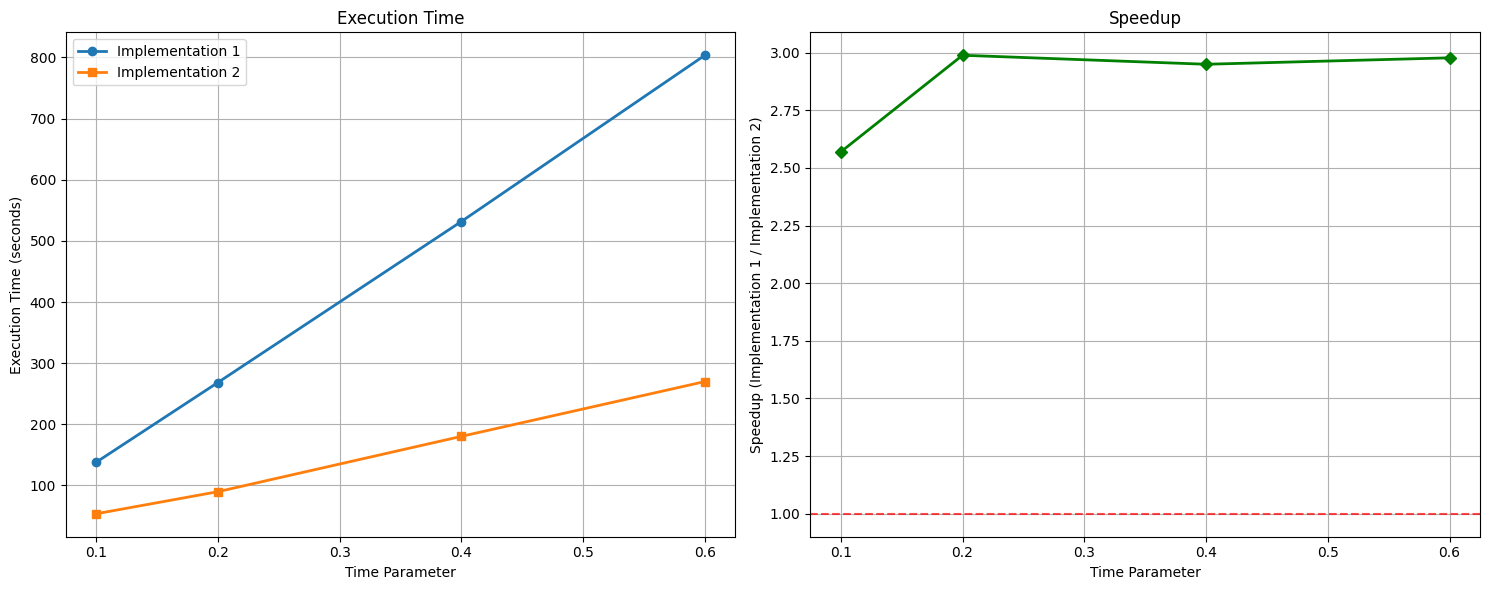

In [10]:

def plot_timing_and_speedup(timing_results, timing_results2, title1="Execution Time", title2="Speedup"):
    time_params = [result['time_param'] for result in timing_results]
    elapsed_times = [result['elapsed_seconds'] for result in timing_results]

    time_params2 = [result['time_param'] for result in timing_results2]
    elapsed_times2 = [result['elapsed_seconds'] for result in timing_results2]

    speedups = []
    common_time_params = []

    for i, t in enumerate(time_params):
        if t in time_params2:
            j = time_params2.index(t)
            speedup = elapsed_times[i] / elapsed_times2[j]
            speedups.append(speedup)
            common_time_params.append(t)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.plot(time_params, elapsed_times, 'o-', label='Implementation 1', linewidth=2)
    ax1.plot(time_params2, elapsed_times2, 's-', label='Implementation 2', linewidth=2)
    ax1.set_xlabel('Time Parameter')
    ax1.set_ylabel('Execution Time (seconds)')
    ax1.set_title(title1)
    ax1.grid(True)
    ax1.legend()

    ax2.plot(common_time_params, speedups, 'D-', color='green', linewidth=2)
    ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.7)  # Reference line
    ax2.set_xlabel('Time Parameter')
    ax2.set_ylabel('Speedup (Implementation 1 / Implementation 2)')
    ax2.set_title(title2)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_timing_and_speedup(timing_results, timing_results2)
